In [1]:
### general
import numpy as np
import pickle
import matplotlib.pyplot as plt
plt.style.use('stefan.mplstyle')

### astropy
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table, join

### project-specific
import sys
sys.path.append('../')
sys.path.append('../../')
import corecomposition as cc
import WD_models

# Define the Gaia DR3 source_id you're interested in
bronze = Table.read('../data/processed/bronze.csv')
silver = Table.read('../data/processed/silver.csv')
gold = Table.read('../data/processed/gold.csv')

In [2]:
photo = cc.photometry.fetch_photometry(bronze['wd_source_id']) # fetch PANSTARRS and DES photometry for the source_ids in the sample
catalog = join(bronze, photo, keys_left='wd_source_id', keys_right='source_id') # join the two on the wd source_id

In [3]:
# information needed for MCMC fitting each target
source_ids = catalog['wd_source_id'] # array of source_ids
coords = [SkyCoord(frame="galactic", l=catalog['wd_l'][i]*u.deg, b=catalog['wd_b'][i]*u.deg, distance = catalog['r_med_geo'][i] * u.pc) for i in range(len(catalog))] # contains the locations of each target
astrometric_params = catalog['wd_astrometric_params_solved'] # used for correcting g-band in Tyler's code
photo = np.array([catalog['wd_phot_g_mean_mag'], catalog['wd_phot_bp_mean_mag'], catalog['wd_phot_rp_mean_mag']]).T # the basic Gaia photometry
e_photo = np.array([catalog['wd_e_gmag'], catalog['wd_e_bpmag'], catalog['wd_e_rpmag']]).T # Gaia photometry error
initial_params = np.array([[10000]*len(catalog), catalog['cmd_radius']]).T # initial guesses

In [4]:
obj = cc.photometry.Photometry(source_ids, coords, astrometric_params, photo, e_photo, initial_params)

100%|██████████| 30/30 [00:00<00:00, 311.15it/s]


In [5]:
# 1307515077152381568
obj.bands[0]

array(['Gaia_G', 'Gaia_BP', 'Gaia_RP', 'PS1_g', 'PS1_r', 'PS1_i', 'PS1_z',
       'PS1_y'], dtype='<U7')

In [6]:
i = 14
source_ids = obj.source_ids[i]
distance = obj.geometry[i].distance.value
bands = obj.bands[i]
photomet = obj.photometry[i]
e_photomet = obj.e_photometry[i]
initial_guess = obj.initial_guess[i]

base_wavl, model_spec, model_spec_low_logg, table = cc.interpolator.utils.build_warwick_da()
build_spec = lambda best_est, distance : 4*np.pi*model_spec((best_est[0], 9)) * ((best_est[1] * 6.957e8) / (distance * 3.086775e16))**2

In [7]:
photomet

array([19.46773529, 19.61324883, 19.00999641, 19.53759766, 18.81983757,
       18.60214043, 18.6189537 , 18.03649712])

In [8]:
import pickle

with open('../data/cleaned/radius_chains_warwick_da.pkl', 'rb') as f:
    warwick_da_chains = pickle.load(f)

with open('../data/cleaned/radius_chains_CO_Hdef.pkl', 'rb') as f:
    co_hdef_chains = pickle.load(f)

with open('../data/cleaned/radius_chains_CO_Hrich.pkl', 'rb') as f:
    co_hrich_chains = pickle.load(f)

In [9]:
source_ids = obj.source_ids
radius_med = []
radius_low = []
radius_high = []

for wdid in source_ids:
    mcmc = np.percentile(warwick_da_chains[wdid][:,1],[16,50,84])
    unc = np.diff(mcmc)
    radius_med.append(mcmc[1])
    radius_low.append(unc[0])
    radius_high.append(unc[1])

radius_table = Table()
radius_table['wd_source_id'] = source_ids
radius_table['radius_med'] = radius_med
radius_table['radius_low'] = radius_low
radius_table['radius_high'] = radius_high

In [10]:
catalog = join(catalog, radius_table, keys='wd_source_id')
catalog['radius_sigma'] = (catalog['radius_med'] - catalog['cmd_radius'])
silver = np.isin(catalog['wd_source_id'], silver['wd_source_id'])
gold = np.isin(catalog['wd_source_id'], gold['wd_source_id'])

<>:4: SyntaxWarning: invalid escape sequence '\o'
<>:4: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_119100/3410762465.py:4: SyntaxWarning: invalid escape sequence '\o'
  ax1.set_ylabel('$R_{CMD}-R_{MCMC}$ [$R_\odot$]')


Text(0.5, 0, 'WD RUWE')

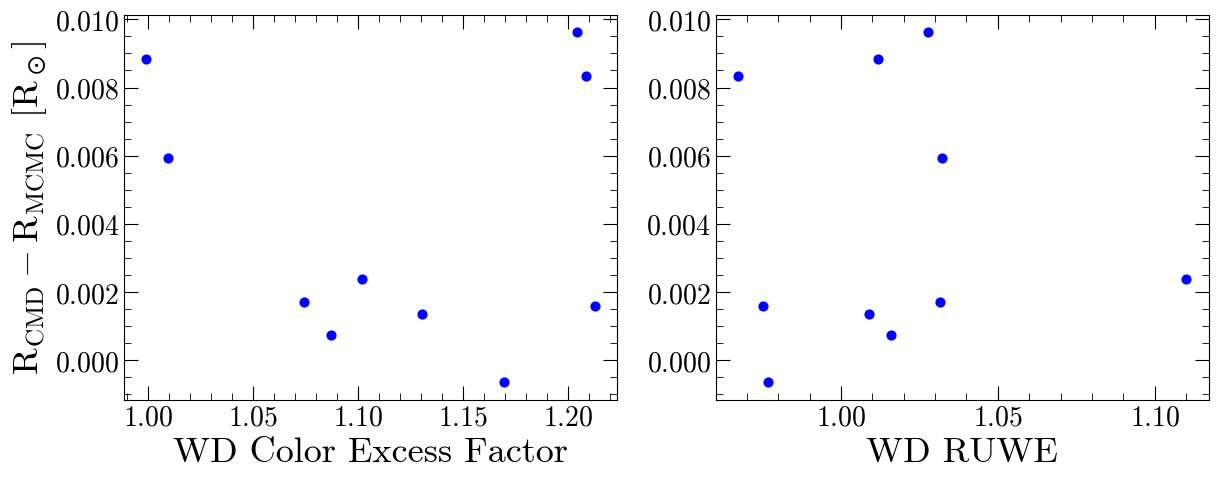

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,5))
ax1.scatter(catalog[silver]['wd_phot_bp_rp_excess_factor'], catalog[silver]['radius_sigma'], s=40, c = 'blue')
ax1.set_xlabel('WD Color Excess Factor')
ax1.set_ylabel('$R_{CMD}-R_{MCMC}$ [$R_\odot$]')

ax2.scatter(catalog[silver]['wd_ruwe'], catalog[silver]['radius_sigma'], s=40, c = 'blue')
ax2.set_xlabel('WD RUWE')


In [12]:
import pyphot
filter_library = pyphot.get_library()

def make_ps1_cmd(catalog):
    g = catalog['PS1_g'].data
    r = catalog['PS1_r'].data
    lib = pyphot.get_library()
    filters = [lib['PS1_g'], lib['PS1_r'], lib['PS1_i'], lib['PS1_z'], lib['PS1_y']]
    vega_zeros = np.array([filt.Vega_zero_Jy.value for filt in filters])

    # converts to mag
    g_jy = vega_zeros[0] * 10**(g / -2.5)
    r_jy = vega_zeros[1] * 10**(r / -2.5)

    g_ab = - 2.5 * np.log10(g_jy * 1e-23) - 48.594
    r_ab = - 2.5 * np.log10(r_jy * 1e-23) - 48.594
    return (g_ab - r_ab).filled(-999), g_ab.filled(-999), r_ab.filled(-999), g_jy, r_jy

def logg_cmd_position(radarray, loggarray, lowmass = 'f', midmass = 'f', highmass = 'f', bands=('bp3-rp3', 'G3')):
    font_model = WD_models.load_model(lowmass, midmass, highmass, 'H', HR_bands = bands)
    rsun_logg_to_m = WD_models.interp_xy_z_func(x = font_model['color'], y = font_model['logg'],\
                                                z = font_model['Mag'], interp_type = 'linear')
    mass = rsun_logg_to_m(radarray, loggarray)
    return mass

colors = np.linspace(-0.5, 1, 100)
gaia_theoretical_rvs_7 = logg_cmd_position(colors, 7, 'f', 'f', 'f', bands=('bp3-rp3', 'G3'))
gaia_theoretical_rvs_7_5 = logg_cmd_position(colors, 7.5, 'f', 'f', 'f', bands=('bp3-rp3', 'G3'))
gaia_theoretical_rvs_8 = logg_cmd_position(colors, 8, 'f', 'f', 'f', bands=('bp3-rp3', 'G3'))
gaia_theoretical_rvs_9 = logg_cmd_position(colors, 9, 'f', 'f', 'f', bands=('bp3-rp3', 'G3'))

ps1_theoretical_rvs_7 = logg_cmd_position(colors, 7, 'f', 'f', 'f', bands=('Pg-Pr', 'Pr'))
ps1_theoretical_rvs_7_5 = logg_cmd_position(colors, 7.5, 'f', 'f', 'f', bands=('Pg-Pr', 'Pr'))
ps1_theoretical_rvs_8 = logg_cmd_position(colors, 8, 'f', 'f', 'f', bands=('Pg-Pr', 'Pr'))
ps1_theoretical_rvs_9 = logg_cmd_position(colors, 9, 'f', 'f', 'f', bands=('Pg-Pr', 'Pr'))

/home/arsen/miniconda3/envs/core-composition/lib/python3.12/site-packages/numpy/ma/core.py:6980: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


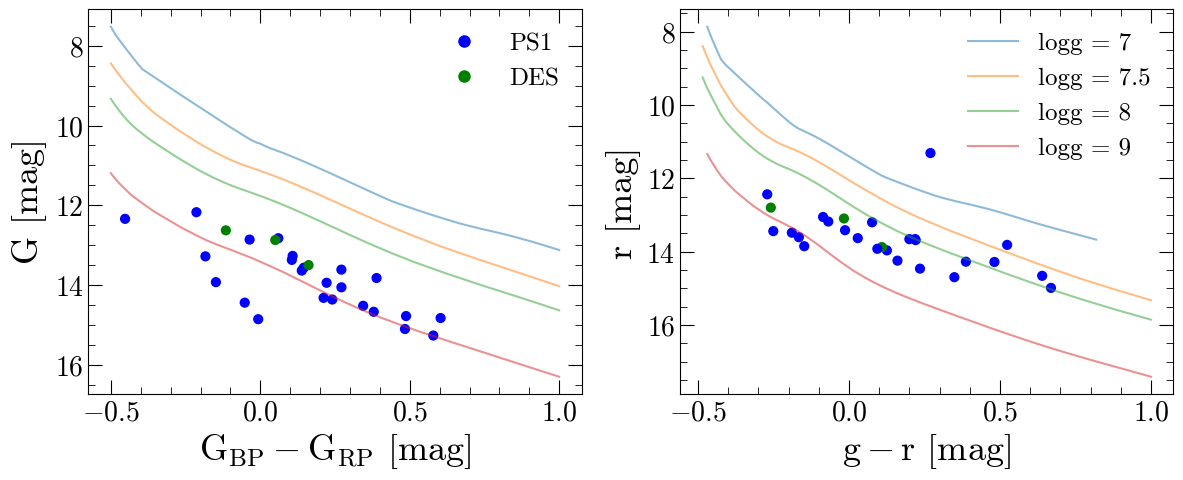

In [13]:
from matplotlib.lines import Line2D

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,5))

temp = np.all([catalog['PS1_r'] > -50, catalog['PS1_g'] > -50], axis = 0)
colors_mapping = {"des": "green", "ps1": "blue"}
source_colors = [colors_mapping.get(cat, "black") for cat in catalog[temp]['source']]

a = 0.5
ax1.plot(colors, gaia_theoretical_rvs_7, alpha = a)
ax1.plot(colors, gaia_theoretical_rvs_7_5, alpha = a)
ax1.plot(colors, gaia_theoretical_rvs_8, alpha = a)
ax1.plot(colors, gaia_theoretical_rvs_9, alpha = a)

scatter = ax1.scatter(catalog[temp]['bpmag_dereddened'] - catalog[temp]['rpmag_dereddened'], catalog[temp]['wd_m_g'], s = 40, c = source_colors, label=colors_mapping)
ax1.invert_yaxis()
ax1.set_xlabel('$G_{BP}-G_{RP}$ [mag]')
ax1.set_ylabel('$G$ [mag]')
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='PS1', markerfacecolor='blue', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='DES', markerfacecolor='green', markersize=10)
]
ax1.legend(handles=legend_elements, framealpha=0)

ax2.plot(colors, ps1_theoretical_rvs_7, alpha = a, label = 'logg = 7')
ax2.plot(colors, ps1_theoretical_rvs_7_5, alpha = a, label = 'logg = 7.5')
ax2.plot(colors, ps1_theoretical_rvs_8, alpha = a, label = 'logg = 8')
ax2.plot(colors, ps1_theoretical_rvs_9, alpha = a, label = 'logg = 9')

g_r, g, r, g_jy, r_jy = make_ps1_cmd(catalog)

ax2.scatter(g_r[temp], r[temp] - 5 * (np.log10(catalog[temp]['r_med_geo']) - 1), s = 40, c = source_colors)
ax2.invert_yaxis()
ax2.set_xlabel('$g - r$ [mag]')
ax2.set_ylabel('r [mag]')
ax2.legend(framealpha=0)


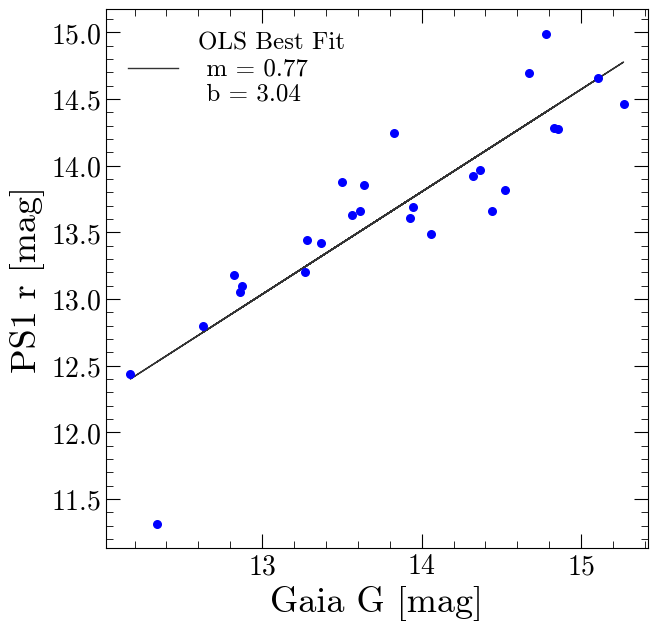

: 

In [14]:
x = catalog[temp]['wd_m_g']
y = r[temp] - 5 * (np.log10(catalog[temp]['r_med_geo']) - 1)
m, b = np.polyfit(x, y, 1)

plt.scatter(x, y, s = 30, c = 'blue')
plt.plot(x, m*x+b, c = 'k', alpha = 0.8, zorder = 0, lw = 1, label = f'OLS Best Fit\n m = {m:2.2f}\n b = {b:2.2f}')
plt.xlabel('Gaia G [mag]')
plt.ylabel('PS1 r [mag]')
plt.legend(framealpha=0)

## Single White Dwarfs

In [15]:
from astroquery.xmatch import XMatch

gaiawds = Table.read('https://cdsarc.cds.unistra.fr/ftp/J/MNRAS/508/3877/maincat.dat.gz', format='ascii')

Could not import regions, which is required for some of the functionalities of this module.


In [ ]:
def radius_from_cmd(catalog, radius_cutoff):
    newton_G = 6.674e-11
    mass_sun = 1.9884e30
    radius_sun = 6.957e8

    model = WD_models.load_model(low_mass_model='Bedard2020',
                                middle_mass_model='Bedard2020',
                                high_mass_model='ONe',
                                atm_type='H',
                                HR_bands=('bp3-rp3', 'G3'))

    bp3_rp3 = catalog['bpmag_dereddened'] - catalog['rpmag_dereddened']
    G3 = catalog['gmag_dereddened'] - 5 * np.log10(catalog['r_med_geo']) + 5
    logg = model['HR_to_logg'](bp3_rp3, G3)
    mass = model['HR_to_mass'](bp3_rp3, G3)

    catalog['cmd_radius'] = np.sqrt((newton_G * mass * mass_sun) / (10**logg/100)) / radius_sun
    return catalog[catalog['cmd_radius'] < radius_cutoff]

highmass_gaiawds = radius_from_cmd(catalog, 9)